# Deep Neural Network - Actual model
(Baseline model in other file)

In [8]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

import statistics
import math

from oversampling import one_hot, smote_loop
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics, initializers
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


In [11]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')
data.replace({0: -1})

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

wat info over model hieronder hier aub TODO

In [17]:
# Actual model

def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5, class_weight=10, 
                      verbose=0, plot=True):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. 
    It is possible to adjust for how many epochs the model is trained and how to weigh the sparse class.
    
    INPUT:
    
    model:        model architecture defined before calling this function
    class_weight:  errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
                  For some reason ... !!!!!!! TODO
    verbose:      False: no text per epoch
                  True: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    OUTPUT: 
    
    predictions_train: vector of training predictions
    predictions_test:  vector of test predictions
    history:           dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys. Return history to be able to access this model
                       information outside of the function.
    
    """
   
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # Turn off warnings (annoying bug in tensorflow)
    tf.get_logger().setLevel('ERROR')
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: class_weight}],
                        #sample_weight=[None],
                        # waarom staat dit uit? TODO
                        verbose=verbose
                       )
    
    # Turn warnings on again 
    tf.get_logger().setLevel('INFO')

    # Predict the classes of the training data
    # Output is a continuous value between 0 and 1, so add a sort of 'hardmax' function to get it into class 0 or 1
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs if requested by function call
    if plot:
        
        # Make subplots
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
        
        # Plot accuracies in one plot
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')
        axs[0].legend(['train', 'test'], loc='upper left')


        # Plot the loss over epochs in the other plot
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history



In [21]:
def get_model(train_data, hidden_layers=1, nodes=[20], activation='relu', dropout_rate=[]):
    """
    Get_model creates a sequential Neural Network with layers based on the input parameters.
    
    INPUT:
    
    train_data:      Training dataset, used to define input layer's shape
    hidden_layers:   Number of hidden layers; default is 1 hidden layer.
    nodes:           List, number of nodes for each hidden layer. Length of list should be equal to amount of hidden layers, 
                     default amount of nodes is 20.
    activation:      Activation function for hidden layers, default is ReLu.
    dropout_rate:    List, rate of dropout if dropout is used. Default is empty, for if no dropout used.
    
    OUTPUT:
    model:           A full sequential model, to be compiled in the function train_and_predict().

    """
    assert len(nodes) == hidden_layers, 'length of list of nodes should be same as defined number of hidden layers'
    
    # Get the amount of input features for the nodes in the first layer
    input_shape = np.shape(train_data)[1]

    # Weights are initialized around a mean of 0, with 0.2 standard deviation
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.2, seed=12345)
    
    # Create the model
    model = models.Sequential()

    # First layer contains as many input nodes as there are features
    model.add(Input(shape=(input_shape)))

    # Loop over the number of hidden layers to create each hidden layer
    for layer in range(hidden_layers):
        
        # Optionally add dropout layers, if the dropout_rate list is not empty
        if dropout_rate:
            assert len(dropout_rate) == hidden_layers, 'dropout_rate should be defined for each layer'
            
            # Get the dropout rate for this specific layer and apply it
            model.add(layers.Dropout(dropout_rate[layer]))
            
        # Add layer with specified number of nodes and activation function
        model.add(layers.Dense(nodes[layer], activation=activation, kernel_initializer=initializer))

    # Output layer with 1 node ( we have only 1 output class, 0 or 1 for stroke) and a sigmoid activation function
    model.add(layers.Dense(1, 'sigmoid'))

    return model




### Model without cross-validation
TODO wat is dit? standaardmodel?

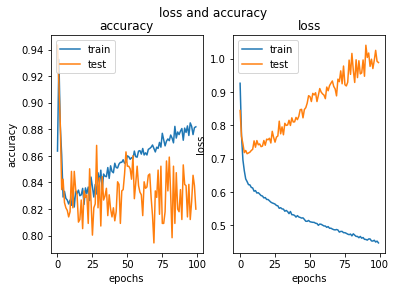

train metrics: 

accuracy: 86.5905 % 

balanced accuracy: 87.5395 %
sensitivity: 0.8859
specificity: 0.8649 

confusion matrix: 
[[2522  394]
 [  17  132]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 81.9961 % 

balanced accuracy: 59.2325 %
sensitivity: 0.3400
specificity: 0.8447 

confusion matrix: 
[[821 151]
 [ 33  17]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [23]:
# Make a model with 2 hidden layers and dropout
model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        class_weight = 10, plot=True,
                                                        epochs=100, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)

### Parameter optimization

##### Class weights

The code below performs training and validation of the DNN model using different class weights.
The different output metrics are then plotted as a function of the class weights to evaluate the weighing effect.

100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


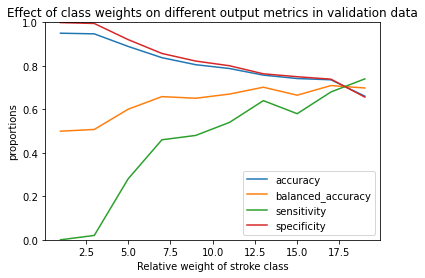

In [25]:
# Test different class weights and plot accuracy and sensitivity

def compare_class_weights(model, train_data, train_labels, val_data, val_labels, 
                          class_weights=range(1, 21, 2), epochs=30):
    """
    This function tries out different class weights on a model and plots the different output metrics (validation accuracy, 
    balanced accuracy etc.) as a function of class_weight (No k-fold cross-validation applied).
    
    INPUT: 
    
    model:         Model as defined by the function get_model()
    train_data:    Training data
    train_labels:  Class labels of training dataset
    val_data:      Validation data
    val_labels:    Class labels of validation dataset.
    class_weights: List of weights to try; default range of 1 to 21 with steps of 2.
    epochs:        Number of epochs for training of the model. Default is 30 epochs.
    
    OUTPUT:        Shows a plot to visually compare effect of class_weights on accuracy, balanced accuracy, precision and
                    specificity.
    """
    # Initialize metrics
    accuracies_val = []
    sensitivities_val = []
    balanced_accuracies_val = []
    specificities_val = []
    
    # Loop over all class weights and train and predict on the model
    # tqdm times every loop of the for loop
    for weight in tqdm(class_weights):

        # Train and predict 
        predictions_train, predictions_val, history = train_and_predict(model, train_data, 
                                                              train_labels, val_data, val_labels,
                                                              epochs=epochs, verbose=0, plot=False,
                                                              class_weight=i)

        # Get the metrics
        accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
        conmat = confusion_matrix(val_labels, predictions_val)
        
        # TODO is hier niet een functie voor?
        sensitivity = conmat[1,1] / sum(conmat[1,:])
        specificity = conmat[0,0] / sum(conmat[0,:])
        
        # Append all the accuracies to their respective lists
        accuracies_val.append(accuracy_val)
        balanced_accuracies_val.append(balanced_accuracy_val)
        sensitivities_val.append(sensitivity)
        specificities_val.append(specificity)
    
    ## Plot metrics over  class weights.
    plt.plot(class_weights, accuracies_val)
    plt.plot(class_weights, balanced_accuracies_val)
    plt.plot(class_weights, sensitivities_val)
    plt.plot(class_weights, specificities_val)
    plt.ylim(0, 1)
    plt.title('Effect of class weights on different output metrics in validation data')
    plt.ylabel('proportions')
    plt.xlabel('Relative weight of stroke class')
    plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
    plt.show() 

model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

compare_class_weights(model, train_data, train_labels, val_data, val_labels, 
                      class_weights=range(1, 21, 2), epochs=50)



### k-fold cross-validation

The pipeline below is used for actual model evaluation.

In [28]:
# Datasets for k-fold cross-validation
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Get cross-validation data and test_data (cross validation data will be further split into train and validation data in
# function)
# Split works differently than in the other model so we have to re-import the data
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

In [51]:
def k_fold_validation(X, y, model, k=5, class_weight=10, epochs=5, to_return=['metrics', 'history']):
    """
    Uses k-fold cross-validation to estimate average training and validation accuracies over different splits. It uses all 
    training/validation data and resplits it 5 times into a training and validation set. It then performs training and 
    testing of the model and takes the average of accuracies over all 5 folds.
    
    INPUT:
    
    X:              Data array containing all features of training and validation data for cross-validation
    y:              Labels of X data
    model:          Model as returned by the function get_model()
    k:              Number of folds for cross-validation
    class_weight:   Relative weight of stroke class cost for model training (ratio = 1:class_weight). Default is 10.
    epochs:         Number of epochs
    to_return:      List with either one or two strings:
                    'metrics': returns all relevant metrics after all epochs are finished, averaged over k splits.
                    'history': returns the loss and accuracy of train and validation data after each epoch, 
                               averaged over k splits.
    
    OUTPUT:         Depends on the value from to_return (see INPUT): ['metrics', 'history']. The returns are both tuples.
    
    metrics (7-item tuple): 
                    - avg_acc_train: average accuracy training folds
                    - avg_bal_acc_train, average balanced accuracy training folds
                    - avg_acc_val, average accuracy validation folds
                    - avg_bal_acc_val, average balanced accuracy validation folds
                    - avg_sens, average sensitivity for validation folds
                    - avg_spec, average specificity for validation folds
                    - conmat, confusion matrix of validation fold predictions.
                    
    history (4-item tuple):
                    - avg_loss_over_epochs: average loss for each epoch training folds
                    - avg_acc_over_epochs, average accuracy for each epoch training folds
                    - avg_loss_over_epochs_val: average loss for each epoch validation folds
                    - avg_acc_over_epochs_val: average accuracy for each epoch validation folds
    
    """
    # Set metrics and history to None, so that there is something to return if they are not actually requested
    metrics_mean = None
    history = None
    
    # Initialize metrics if it's requested later
    if 'metrics' in to_return:
        accuracies_train = []
        balanced_accuracies_train = []
        accuracies_val = []
        balanced_accuracies_val = []
        sensitivities = []
        specificities = []
        
        # geef dit een andere naam want beetje onduidelijk wat dit nou is
        histories = []
        conmats = np.zeros((2,2))
    
    # Get object that splits the data in 5 equal stratified folds
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)
    
    # Loop over the training and test indexes of those 5 datasets
    for train_index, test_index in sss.split(X, y):
        
        # Split data and labels into training and testing data and labels
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        # Find the best fitting theta for this training set using the Normal equation
        # TODO wat bedoelen jullie met theta
        predictions_train, predictions_val, history = train_and_predict(model, x_train, y_train, x_val, y_val,
                                                                        epochs=epochs, class_weight=class_weight, 
                                                                        verbose=0, plot=False)
        # Append the histories if requested
        if 'history' in to_return:
            
            # Store history of each split
            histories.append(history)
        
        # Calculate metrics if requested
        if 'metrics' in to_return:
            
            # Get metrics for this split
            accuracy_train, balanced_accuracy_train = get_metrics(y_train, predictions_train, verbose=False)
            accuracy_val, balanced_accuracy_val = get_metrics(y_val, predictions_val, verbose=False)
            
             # Store metrics for this split
            accuracies_train.append(accuracy_train)
            balanced_accuracies_train.append(balanced_accuracy_train)
            accuracies_val.append(accuracy_val)
            balanced_accuracies_val.append(balanced_accuracy_val)
            
            # Get confusion matrix to calculate sensitivity and specificity.
            conmat = confusion_matrix(y_val, predictions_val)
            sensitivity = conmat[1,1] / sum(conmat[1,:])
            specificity = conmat[0,0] / sum(conmat[0,:])
            
            # Return the confusion matrix by adding it to our empty array and add sensitivies and specificities
            conmats += np.array(conmat)
            sensitivities.append(sensitivity)
            specificities.append(specificity)
    

    # Do the last calculations needed for metrics if it's going to be returned
    if 'metrics' in to_return:
        
        # Append all metrics together
        metrics_all = [accuracies_train, balanced_accuracies_train, accuracies_val, 
                       specificities, balanced_accuracies_val, sensitivities]
        metrics_mean = []
        
        # Loop over all metrics and compute and store their mean over all k splits.
        for metric in metrics_all:
            
            # Compute average metrics over all k splits.
            metrics_mean.append(statistics.mean(metric))
        
        # Divide the confusion matrixes by the number of folds, as we've summed over each fold
        metrics_mean.append(conmats / k)
        
        # Transform the metrics to a tuple for easy unpacking
        metrics_mean = tuple(metrics_mean)
        
    # Do the last calculations for history if it's going to be returned
    if 'history' in to_return:
        
        # List to append all metrics to
        history_metrics = []
        
        # TODO jeroen wat gebeurt hier help
        #history_metrics_names = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        for metric_names, metric_values in history.history.items():
            #print(history.history)
            # compute average loss and accuracy over all k splits for each epoch
            metric_history = np.zeros(len(metric_values))
        
            # Loop over the list of history dictionaries for each k split
            for history_dict in histories:
                metric_history = metric_history + np.array(history_dict.history[metric_names])
                # add up data of each split for the loss and accuracy 
                # training data     
                
            history_metrics.append(metric_history / k)
        history = tuple(history_metrics)
        
    return metrics_mean, history_metrics
    


In [52]:
# Create model
model = get_model(X, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

# Number of training epochs.
epochs = 30

# Perform 5-fold cross-validation
metrics, history = k_fold_validation(np.array(X), np.array(y), model, k = 5, 
                                     class_weight = 15, epochs = epochs, to_return=['metrics','history'])

# Unpack tuples
avg_loss_over_epochs, avg_acc_over_epochs, avg_loss_over_epochs_val, avg_acc_over_epochs_val = history
avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec, conmat = metrics

average accuracy validation data: 88.1418 % 

average balanced accuracy validation data: 91.1311 %
sensitivity: 0.6057
specificity: 0.3000 

confusion matrix: 
[[709.  69.]
 [ 28.  12.]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



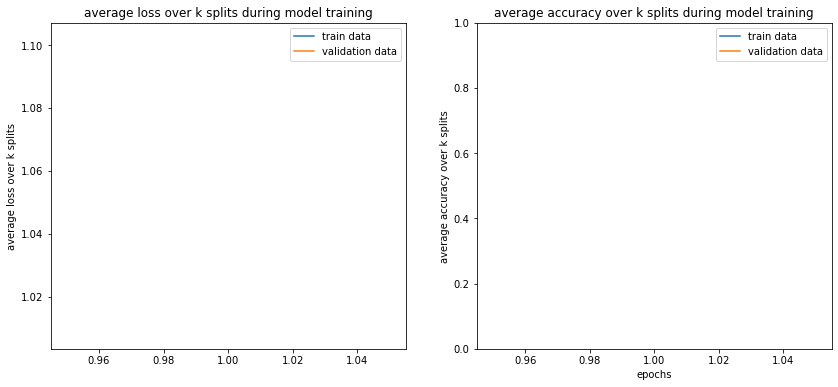

In [53]:
#  Print metrics
print(f'average accuracy validation data: {avg_acc_val*100:.4f} % \n')
print(f'average balanced accuracy validation data: {avg_bal_acc_val*100:.4f} %')
print(f'sensitivity: {avg_sens:.4f}')
print(f'specificity: {avg_spec:.4f} \n')
print('confusion matrix: ')
print(f'{conmat} \n')
print('[["True Negative", "False Positive"] \n ["False Negative", "True Positive"]] \n')

# Plot the loss and accuracy during learning of the model, averaged over k splits using cross-validation
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
fig.figsize = (10, 8)

# Get the number of epochs
epochs = len(avg_loss_over_epochs)

# Plot the average loss for each epoch
# TODO waarom doe je de range zo?
# miss beter even een x = aanmaken evt
axs[0].plot(range(1, epochs + 1), avg_loss_over_epochs)
axs[0].plot(range(1, epochs + 1), avg_loss_over_epochs_val)
axs[0].set_title('average loss over k splits during model training')
axs[0].set_ylabel('average loss over k splits')
axs[0].legend(['train data', 'validation data'], loc='upper right')

# Plot average accuracy of train and validation data for each epoch
axs[1].plot(range(1, epochs + 1), avg_acc_over_epochs)
axs[1].plot(range(1, epochs + 1), avg_acc_over_epochs_val)
axs[1].set_title('average accuracy over k splits during model training')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('average accuracy over k splits')
axs[1].legend(['train data', 'validation data'], loc='upper right')
axs[1].set_ylim([0,1])
plt.show()

### Data augmentations - oversampling

zet even bij waarom jullie weer data inladen TODO

In [ ]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = True, normalize = True)

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

# Define categorial features
# wat is dit? TODO
n_features = np.array([True, False, True, True, True, True,True, False, False, True])

# Unpack the smote_loop
# Wat is de smote_loop (kort)? TODO
list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, n_features, 0.1, 0.96, 0.05)

# One-hot encode two columns of the validation data
# Waarom? TODO
val_data = one_hot(val_data, ['work_type', 'smoking_status'])

In [ ]:
# Make a model object with the correct input dimensions
# Correct input dimensions van wat? TODO
model = get_model(list_data[0])

# Initiate the oversampling lists
oversampling_val = []
oversampling_val_bal = []
oversampling_sens = []
oversampling_spec = []

# Loop over every dataset and labels with different ratios 
# Ergens wel toelichten wat voor ratios je hier meekrijgt, dat dat dus uit oversampling file komt TODO
for data_res, labels_res in tqdm(zip(list_data, list_labels)):
    
    # Train and predict the network 
    predictions_train, predictions_val, history = train_and_predict(model, data_res, labels_res, val_data, val_labels,epochs=30,
                                                                    verbose=0, plot=False, class_weight=1)
    
    # Get metrics from the network
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
    conmat = confusion_matrix(val_labels, predictions_val)
    
    # Calculate the sensitivity and specificity
    # Hier misschien even een functie voor schrijven als je er geen kan vinden TODO
    sensitivity = conmat[1,1] / sum(conmat[1,:])
    specificity = conmat[0,0] / sum(conmat[0,:])
    
    # Append to lists 
    oversampling_acc.append(accuracy_val)
    oversampling_acc_bal.append(balanced_accuracy_val)
    oversampling_sens.append(sensitivity)
    oversampling_spec.append(specificity)


In [ ]:
# Plot metrics for different oversampling ratios in percentages
plt.plot(list_ratio, np.array(oversampling_val) * 100)
plt.plot(list_ratio, np.array(oversampling_val_bal) * 100)
plt.plot(list_ratio, np.array(oversampling_sens) * 100)
plt.plot(list_ratio, np.array(oversampling_spec) * 100)

plt.ylim(0, 100)
plt.title('Effect of stroke data augmentation on different output metrics in validation data')
plt.ylabel('performance in %')
plt.xlabel('ratio of oversampling')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()  


### Evaluation of the effect of both oversampling and class weights

wat doen jullie hier? TODO

In [66]:
# start stop step, always a little bit higher than the last actual number
oversampling_start = 0.1
oversampling_stop = 0.31
oversampling_step = 0.05

class_weight_start = 1
class_weight_stop = 11
class_weight_step = 2

# Calculate lengths for matrices 
# Hoezo berekenen jullie dit op deze manier? TODO
oversampling_length = math.ceil(( oversampling_stop - oversampling_start ) / oversampling_step)
class_weight_length = math.ceil((class_weight_stop - class_weight_start ) / class_weight_step)

print(np.zeros((oversampling_length, class_weight_length)).shape)
print('(oversampling ratio x class weight ratio)')

(5, 5)
(oversampling ratio x class weight ratio)


vgm hoeft deze cel hieronder er niet meer in toch, aangezien jullie dit ietsjes eerder ook al doen? TODO

In [68]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = True, normalize = True)

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

# Define categorial features
n_features = np.array([True, False, True, True, True, True,True, False, False, True])

# Unpack the smote_loop.
list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, n_features, oversampling_start, 
                                                oversampling_stop, oversampling_step)

# One-hot encode two columns of the validation data
val_data = one_hot(val_data, ['work_type', 'smoking_status'])

# Make a model object with the correct input dimentions
model = get_model(list_data[0], hidden_layers=1, nodes=[20], activation='relu', dropout=False, dropout_rate=[])

In [70]:
# Test different class weights and plot accuracy and sensitivity

# Matrices for the accuracies: 2D array: rows = oversampling, columns is class_weight
accuracies = np.zeros((oversampling_length, class_weight_length))
sensitivities = np.zeros((oversampling_length, class_weight_length))
balanced_accuracies = np.zeros((oversampling_length, class_weight_length))
specificities = np.zeros((oversampling_length, class_weight_length))

# Loop over different dataset oversampling ratio's
for i, (data_res, labels_res) in enumerate(tqdm(zip(list_data, list_labels))):
    #print('oversample', i)
        
    # Loop over different class weights
    for j, weight in enumerate(tqdm(range(class_weight_start, class_weight_stop, class_weight_step))):
        #print('class_weight', j)
    
        # Train and predict
        predictions_train, predictions_val, history = train_and_predict(model, data_res, 
                                                              labels_res, val_data, val_labels,
                                                              epochs=30, verbose=0, plot=False,
                                                              class_weight=weight)
    
        # Get metrics
        accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
        conmat = confusion_matrix(test_labels, predictions_val)
        
        sensitivCity = conmat[1,1] / sum(conmat[1,:])
        specificity = conmat[0,0] / sum(conmat[0,:])
        
        accuracies[i, j] = accuracy_val
        balanced_accuracies[i, j] = balanced_accuracy_val
        sensitivities[i, j] = sensitivity
        specificities[i, j] = specificity 
        
        #print(accuracies)
        
      

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:42<00:00,  8.42s/it]
1it [00:42, 42.12s/it]
100%|██████████| 5/5 [00:44<00:00,  8.85s/it]
2it [01:26, 43.37s/it]
100%|██████████| 5/5 [00:40<00:00,  8.13s/it]
3it [02:07, 42.13s/it]
100%|██████████| 5/5 [00:42<00:00,  8.42s/it]
4it [02:49, 42.12s/it]
100%|██████████| 5/5 [00:42<00:00,  8.47s/it]
5it [03:31, 42.29s/it]


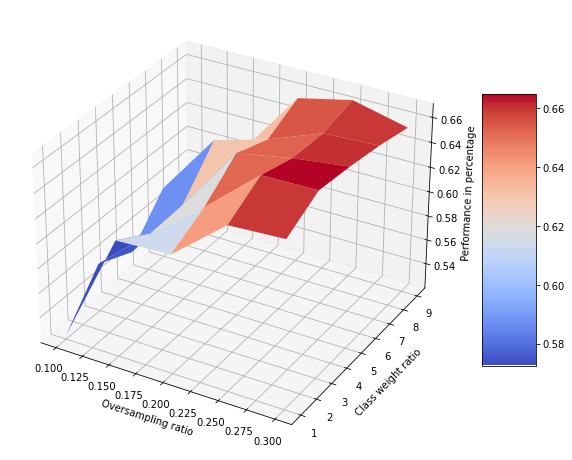

In [77]:
# make 3D figure
fig = plt.figure(figsize=(10,10))

# create 3 axises
ax = fig.add_subplot(111, projection='3d')

X0 = np.arange(oversampling_start, oversampling_stop, oversampling_step)
Y0 = np.arange(class_weight_start, class_weight_stop, class_weight_step)

# make a grid, in order to plot every point
X, Y = np.meshgrid(X0, Y0)

Z = balanced_accuracies 

# make plot 
actual_plot = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

# add colorbar
fig.colorbar(actual_plot, shrink=0.5, aspect=5)

# Label X and Y

ax.set_xlabel('Oversampling ratio')
ax.set_ylabel('Class weight ratio')
ax.set_zlabel('Performance in percentage')

plt.show()